## Noisy RGB pixels + Albedo + Normal, Fit residual, L1+L2 loss, 1/8 U-Net bottleneck

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


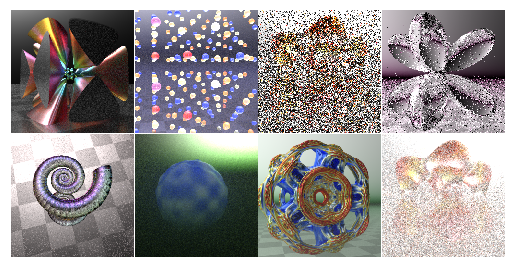

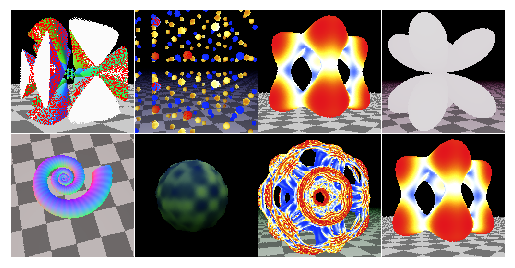

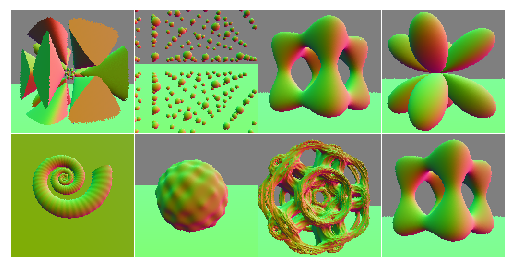

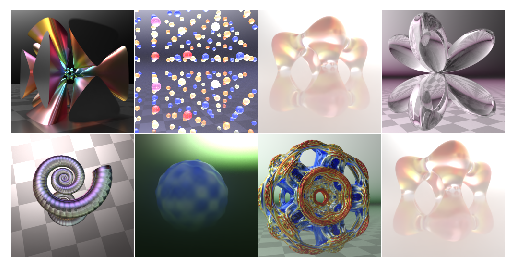

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.econv0a = conv3(11, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.mconv1 = conv3(n2, n3) # 1/8
        self.mconv2 = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv3(n0+n0, n0) # 1
        # self.dconv0 = conv3(n0+n0, 3) # 1
        # self.dconv0 = conv3(n0, 3) # 1
        self.oconva = conv3(n0+n0, 3) # 1
        self.oconvb = conv3(n0, 3) # 1

    def forward(self, input):
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        m1 = self.mconv1(pool(e2)) # 1/8
        m2 = self.mconv2(relu(m1)) # 1/8
        d2 = relu(self.dconv2a(relu(m2))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        # return self.dconv0(do)
        # return self.dconv0b(concat(d0, e0))
        return self.oconva(concat(d0, e0)) + self.oconvb(do)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(11, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0a): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv0b): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (oconva): Conv2d(24,

128 0.49610260128974915
256 0.20808440446853638
384 0.2746162712574005
512 0.2690427601337433
640 0.09798568487167358
768 0.11378200352191925
896 0.062076348811388016
1024 0.045206278562545776
1152 0.13651597499847412
1280 0.0304030142724514
1408 0.06198678910732269
1536 0.04621947929263115
1664 0.04234187304973602
1792 0.021546635776758194
1920 0.037679024040699005
2048 0.078516386449337
2176 0.02614540420472622
2304 0.06787975877523422
2432 0.028838640078902245
2560 0.08919618278741837
2688 0.037808991968631744
2816 0.03265868499875069
2944 0.02420784905552864
3072 0.051656574010849
3200 0.02895987778902054
3328 0.049768365919589996
3456 0.015038887038826942
3584 0.057721592485904694
3712 0.050764236599206924
3840 0.034858427941799164
3968 0.024601202458143234
4096 0.02784348651766777


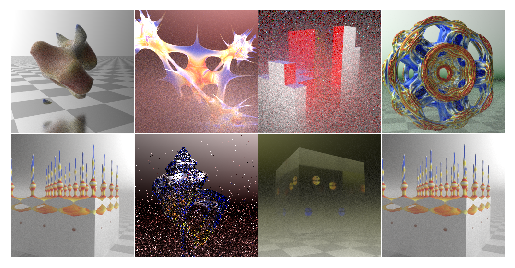

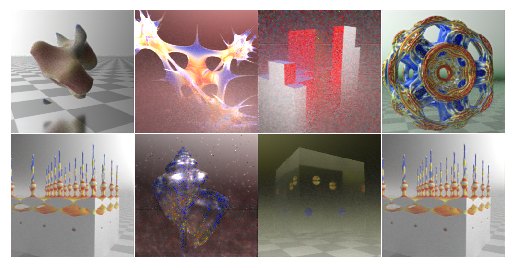

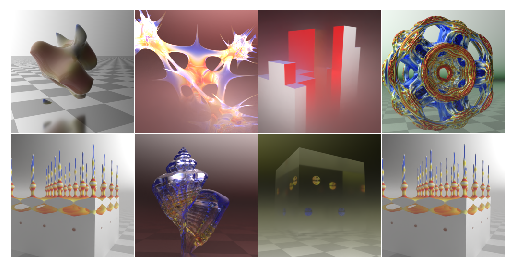

4224 0.04059101641178131
4352 0.05421192944049835
4480 0.03279488533735275
4608 0.02686336636543274
4736 0.02982138656079769
4864 0.023234136402606964
4992 0.06629768013954163
5120 0.03904055804014206
5248 0.018683193251490593
5376 0.041318826377391815
5504 0.06021967530250549
5632 0.025523826479911804
5760 0.04332897812128067
5888 0.03335483372211456
6016 0.026957161724567413
6144 0.030819371342658997
6272 0.04227811098098755
6400 0.014063951559364796
6528 0.025280503556132317
6656 0.08290325105190277
6784 0.042601313441991806
6912 0.05948506295681
7040 0.025656534358859062
7168 0.03295445442199707
7296 0.026914220303297043
7424 0.03351009637117386
7552 0.057045359164476395
7680 0.04035445302724838
7808 0.04963550716638565
7936 0.022942624986171722
8064 0.02867630124092102
8192 0.042187418788671494


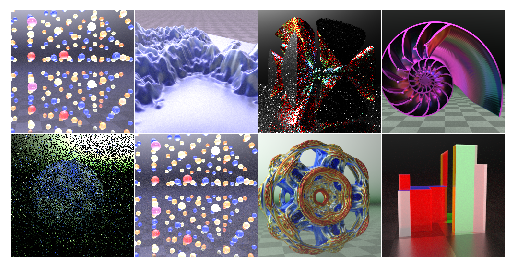

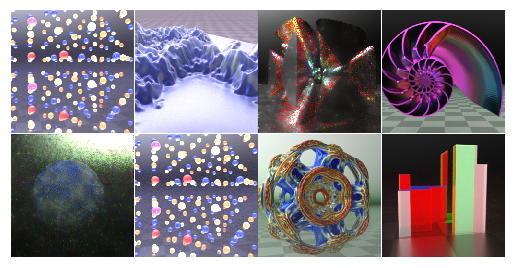

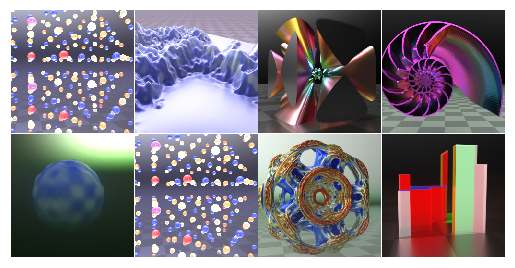

8320 0.024244479835033417
8448 0.05570337548851967
8576 0.04871309921145439
8704 0.008927743881940842
8832 0.021391622722148895
8960 0.010198905132710934
9088 0.02639111690223217
9216 0.05140500143170357
9344 0.027475563809275627
9472 0.029123857617378235
9600 0.013107961975038052
9728 0.02027430385351181
9856 0.011410593055188656
9984 0.014926833100616932
10112 0.009726637974381447
10240 0.02548442780971527
10368 0.01992199569940567
10496 0.0178639218211174
10624 0.03452011197805405
10752 0.01956605352461338
10880 0.021844973787665367
11008 0.01095864549279213
11136 0.03366662561893463
11264 0.03856520727276802
11392 0.012198090553283691
11520 0.031446538865566254
11648 0.025891628116369247
11776 0.021032698452472687
11904 0.010302949696779251
12032 0.012316384352743626
12160 0.02231285162270069
12288 0.02056466042995453


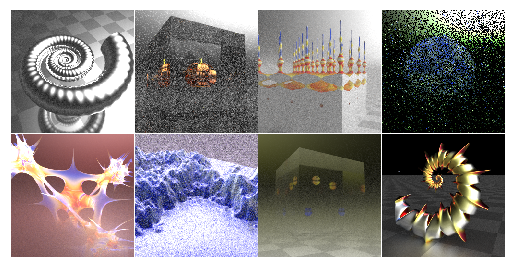

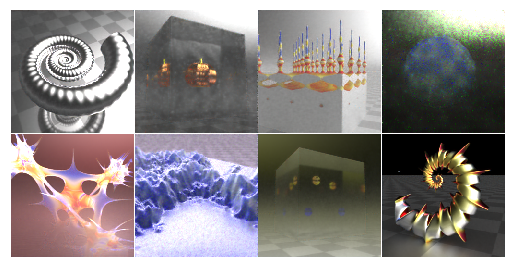

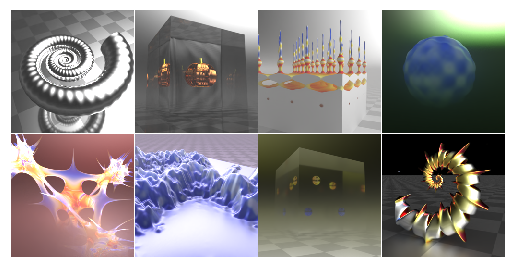

12416 0.02687665820121765
12544 0.022864658385515213
12672 0.03132912516593933
12800 0.03680442273616791
12928 0.0517432764172554
13056 0.012233857996761799
13184 0.013654705137014389
13312 0.03436034917831421
13440 0.03333413600921631
13568 0.018948286771774292
13696 0.019709322601556778
13824 0.011031178757548332
13952 0.010393969714641571
14080 0.01221404131501913
14208 0.03442322835326195
14336 0.012749582529067993
14464 0.016705326735973358
14592 0.016071241348981857
14720 0.0218037236481905
14848 0.010403194464743137
14976 0.044091954827308655
15104 0.015344112180173397
15232 0.02055181935429573
15360 0.011275969445705414
15488 0.015262091532349586
15616 0.03914204239845276
15744 0.047050073742866516
15872 0.010323327034711838
16000 0.047294214367866516
16128 0.03275261074304581
16256 0.02023623138666153
16384 0.025725387036800385


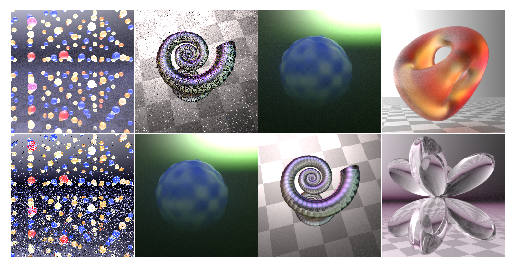

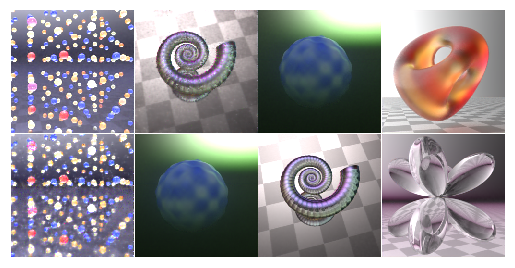

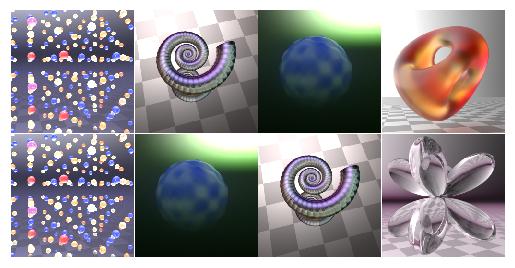

16512 0.02805142104625702
16640 0.022035423666238785
16768 0.01161160133779049
16896 0.016514625400304794
17024 0.023198988288640976
17152 0.029308874160051346
17280 0.010692380368709564
17408 0.01672329194843769
17536 0.03418080508708954
17664 0.02909444272518158
17792 0.03020673431456089
17920 0.021383032202720642
18048 0.008303550072014332
18176 0.030743848532438278
18304 0.049239806830883026
18432 0.02770061045885086
18560 0.02017727866768837
18688 0.011916227638721466
18816 0.0068010021932423115
18944 0.005528153385967016
19072 0.012468981556594372
19200 0.0244666188955307
19328 0.007516534999012947
19456 0.01648496650159359
19584 0.005601093638688326
19712 0.038872748613357544
19840 0.009128662757575512
19968 0.02299746870994568
20096 0.029981544241309166
20224 0.03268567845225334
20352 0.042320117354393005
20480 0.032240696251392365


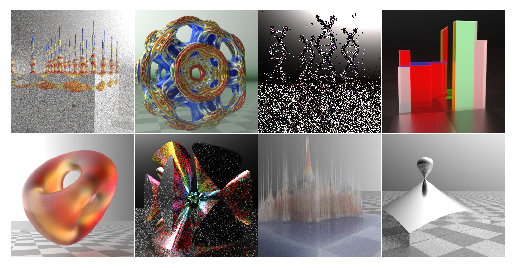

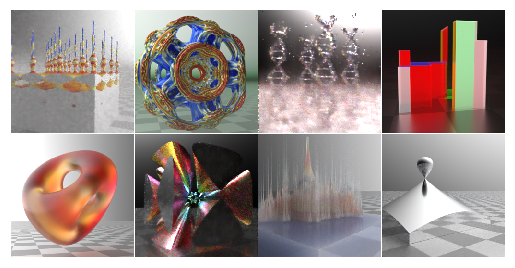

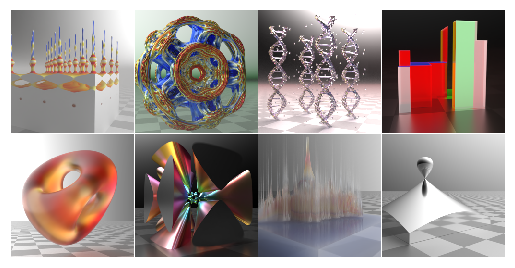

20608 0.023665089160203934
20736 0.04194760322570801
20864 0.015344275161623955
20992 0.0229545459151268
21120 0.01569298841059208
21248 0.022433442994952202
21376 0.026070991531014442
21504 0.03059457428753376
21632 0.024415090680122375
21760 0.02556954137980938
21888 0.02841953933238983
22016 0.03007495030760765
22144 0.02179982140660286
22272 0.017959482967853546
22400 0.014574100263416767
22528 0.011798778548836708
22656 0.018543541431427002
22784 0.03361925110220909
22912 0.010069221258163452
23040 0.019259419292211533
23168 0.024649931117892265
23296 0.02786097303032875
23424 0.01840715855360031
23552 0.01002633385360241
23680 0.030140496790409088
23808 0.011194156482815742
23936 0.021911270916461945
24064 0.017129067331552505
24192 0.014533433131873608
24320 0.012355162762105465
24448 0.03302473574876785
24576 0.03834158927202225


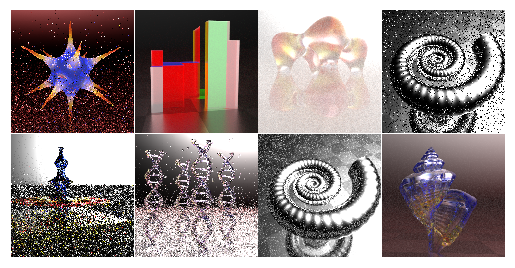

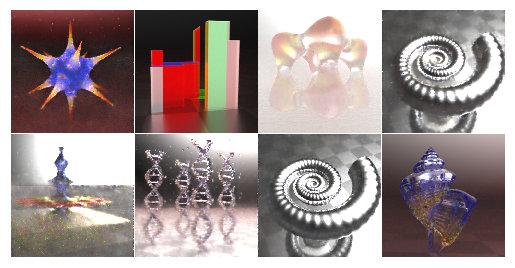

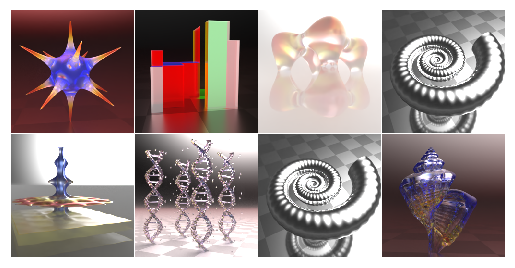

24704 0.01758313551545143
24832 0.009193262085318565
24960 0.014931177720427513
25088 0.020872458815574646
25216 0.028861170634627342
25344 0.018376529216766357
25472 0.01798383519053459
25600 0.019688783213496208
25728 0.020168067887425423
25856 0.01928076334297657
25984 0.008447143249213696
26112 0.044409092515707016
26240 0.024759262800216675
26368 0.01642126590013504
26496 0.015305227600038052
26624 0.028932033106684685
26752 0.025567177683115005
26880 0.0067656803876161575
27008 0.00707483384758234
27136 0.01691182516515255
27264 0.04007318243384361
27392 0.02140652760863304
27520 0.009126723743975163
27648 0.010040165856480598
27776 0.02301056683063507
27904 0.007653391920030117
28032 0.017967920750379562
28160 0.02252054214477539
28288 0.03173188120126724
28416 0.015254028141498566
28544 0.03002350404858589
28672 0.03542669489979744


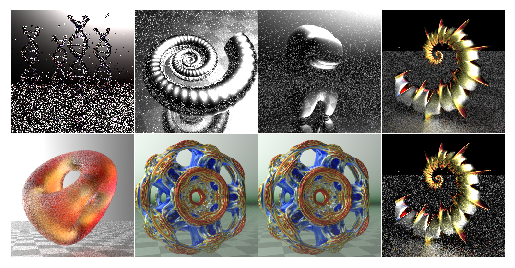

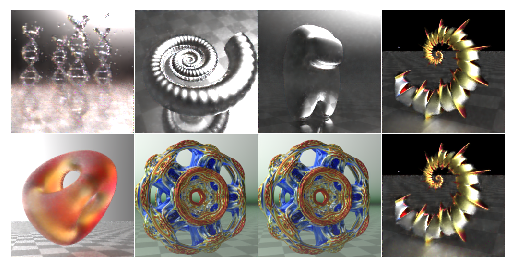

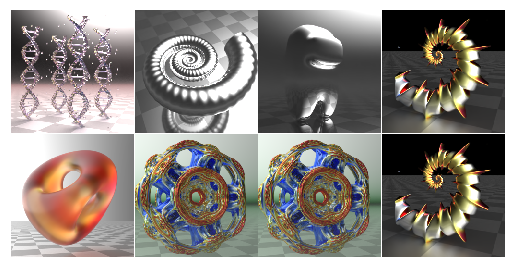

28800 0.02153029851615429
28928 0.009442067705094814
29056 0.011664233170449734
29184 0.012720521539449692
29312 0.017155807465314865
29440 0.023906491696834564
29568 0.018914371728897095
29696 0.014817613177001476
29824 0.029355891048908234
29952 0.023381691426038742
30080 0.010037231259047985
30208 0.012809541076421738
30336 0.031880542635917664
30464 0.006841833237558603
30592 0.01483857724815607
30720 0.03054618462920189
30848 0.03926694765686989
30976 0.01049078069627285
31104 0.017918318510055542
31232 0.031887710094451904
31360 0.010220587253570557
31488 0.018103132024407387
31616 0.030840352177619934
31744 0.013757992535829544
31872 0.021896757185459137
32000 0.02320517972111702
32128 0.013064874336123466
32256 0.02753840759396553
32384 0.016113393008708954
32512 0.034779999405145645
32640 0.011182336136698723
32768 0.01856910064816475


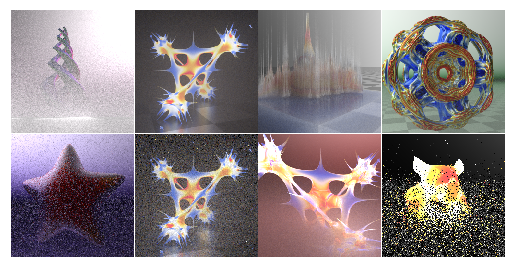

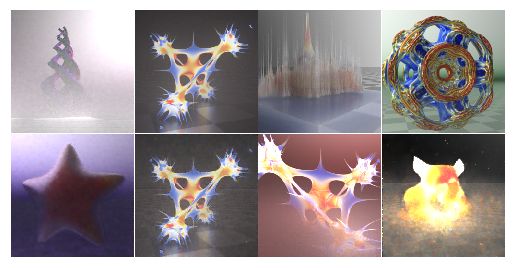

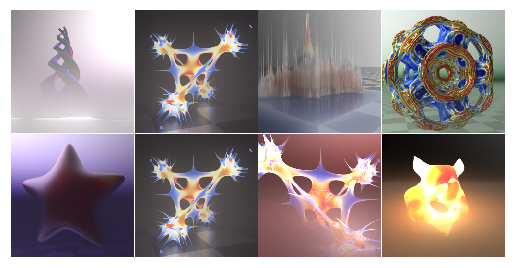

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

def color_norm(c):
    return (c[:,0:1]**2 + c[:,1:2]**2 + c[:,2:3]**2) ** 0.5

def lossfun(output, reference):
    l1 = torch.mean(torch.abs(output-reference))
    l2 = torch.mean((output-reference)**2) / 0.05
    return l1 + l2

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        # x = torch.pow(x, 2.2)
        # y = torch.pow(y, 2.2)
        optimizer.zero_grad()
        m_in = torch.concatenate((
            a[:,0:3], color_norm(a[:,0:3]), # albedo
            a[:,3:6], a[:,3:4]**2+a[:,4:5]**2,  # normal
            x,  # pixels
            ), axis=1)
        output = model(m_in)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        # regl1 = 0.1 * torch.mean(torch.abs(model_params))
        # regl2 = 0.1 * torch.mean(torch.abs(model_params))
        # (loss+regl1+regl2).backward()
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)
            # plot_imgs(torch.pow(x, 1.0/2.2))
            # plot_imgs(torch.pow(torch.clip(output+x,0.0,1.0).detach(), 1.0/2.2))
            # plot_imgs(torch.pow(y, 1.0/2.2))
            model_path = "model4anc_small.pth"
            torch.save(model, model_path)

torch.save(model, model_path)
